# Notebook 3 a

In [1]:
import pandas as pd 
from tqdm.auto import tqdm
from pathlib import Path
import pickle
import numpy  as np 
import matplotlib.pyplot as plt
import os

In [2]:
mouse = 'T240'
data_day = '2019_09_27__T240'
date = '2019_09_27'

HowManyBack = 1

Nb2= 'a'
Nb3='a'

data_dir_output = "/Users/gilmandelbaum/Desktop/outPut"

seq_str = "0a1b2a3a4ab5a6abc10a"

In [3]:
root = Path(data_dir_output+"/"+mouse+"/"+data_day+'/'+str(HowManyBack)+"_Back")
d = mouse+"_"+date+"Notebook_2_"+Nb2+'.pickle'
my_path = root / d 
# open a file, where you stored the pickled data
fileToOpen = open(my_path, 'rb')
# dump information to that file
aligned_behav_photo = pickle.load(fileToOpen)

# Get df/f for photometry data based on sliding window

In [4]:
photometry_all_channel_afterDownSample = aligned_behav_photo[["d2 R","d1 R","d2 L","d1 L"]]

In [5]:
photometry_all_channel_afterDownSample_c = photometry_all_channel_afterDownSample.copy()
photometry_all_channel_afterDownSample_c.to_dict('list');

In [6]:
# from https://stackoverflow.com/questions/40084931/taking-subarrays-from-numpy-array-with-given-stride-stepsize/40085052#40085052
# dang this is fast!
def strided_app(a, L, S):  # Window len = L, Stride len/stepsize = S
    nrows = ((a.size-L)//S)+1
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(a, shape=(nrows, L), strides=(S*n, n))

In [7]:
def get_baseline(data, baseline_win, baseline_fun):

    baseline_win_samples = int(baseline_win)
    padded_data = np.pad(data,
                         (baseline_win_samples // 2,
                          baseline_win_samples // 2 - 1),
                         'edge')

    strides = strided_app(padded_data, baseline_win_samples, 1)
    baseline = np.zeros((strides.shape[0], ), dtype='float32')
    baseline[:] = np.nan

    for k, data_slice in tqdm(enumerate(strides), total=strides.shape[0], desc='Computing baseline'):
        use_data = data_slice[np.isfinite(data_slice)]
        if len(use_data) > 0:
            baseline[k] = baseline_fun(use_data)
            
    return baseline

In [8]:
baseline_fun = lambda x: np.percentile(x, 10)

In [9]:
final_sig = {}

for k, v in photometry_all_channel_afterDownSample_c.items():
    baseline = get_baseline(v, 2000 ,baseline_fun)
    final_sig['{}_f0'.format(k)] = baseline
    final_sig['{}_dff'.format(k)] = (v - baseline) / baseline

In [10]:
use_keys = [_ for _ in final_sig.keys() if 'dff' in _]

In [11]:
tstamps = list(range(len(final_sig ["d2 R_dff"])))

# Plot 10 seconds of photometry data to see how it looks. 

In [12]:
# stash result in a cache directory, for how many back. 
cache_dir_plt = os.path.join(data_dir_output+'/'+mouse+'/'+data_day, str(HowManyBack)+'_Back',"0.plots")
if not os.path.exists(cache_dir_plt):
    os.makedirs(cache_dir_plt)

In [13]:
path_to_plot = cache_dir_plt+"/"+seq_str[:seq_str.index("4")]+"_plot"

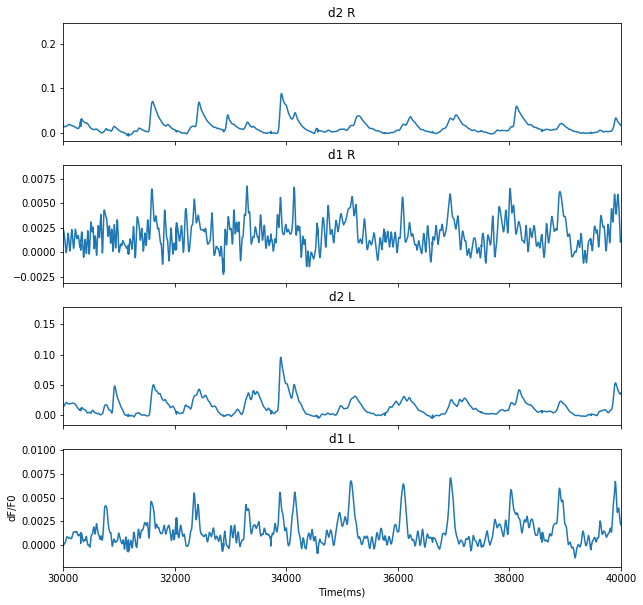

In [15]:
fig, ax = plt.subplots(4, 1,figsize=(10,10),sharex=True, sharey=False)

for _ax, k in zip(ax.flatten(), use_keys):
    _ax.plot(tstamps, final_sig[k])
    _ax.set_title(k.split('_')[0])
    
_ax.set_xlim(30000,40000)
_ax.set_xlabel('Time(ms)')
_ax.set_ylabel('dF/F0')
fig.savefig(path_to_plot+'.pdf')
plt.show()

In [16]:
# update photometry signal after df/f 
photometry_all_channel_df0_dff = pd.DataFrame(final_sig)
photometry_all_channel_df0_dff = photometry_all_channel_df0_dff[["d2 R_dff","d1 R_dff","d2 L_dff","d1 L_dff"]]

In [17]:
actualDffPercent = 100*photometry_all_channel_df0_dff

In [18]:
aligned_behav_photo_dff = aligned_behav_photo
aligned_behav_photo_dff["d2 R"] = actualDffPercent["d2 R_dff"].values
aligned_behav_photo_dff["d1 R"] = actualDffPercent["d1 R_dff"].values
aligned_behav_photo_dff["d2 L"] = actualDffPercent["d2 L_dff"].values
aligned_behav_photo_dff["d1 L"] = actualDffPercent["d1 L_dff"].values

In [19]:
processed_data = aligned_behav_photo_dff

In [20]:
root = Path(data_dir_output+"/"+mouse+"/"+data_day+'/'+str(HowManyBack)+"_Back")
d = mouse+"_"+date+"Notebook_3_a.pickle"
#theDataFrame = "Notebook_1_"+Nb1+'.pickle'
my_path = root / d 
my_file = open(my_path, 'wb')
my_file = pickle.dump(processed_data,my_file)